In [1]:
import numpy as np
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
from Models.selective_sequential import *
from Loss.triplet_regularized import *
from session import *
from LR_Schedule.cyclical import Cyclical
from LR_Schedule.cos_anneal import CosAnneal
from LR_Schedule.lr_find import lr_find
from callbacks import *
from validation import *
import Datasets.ImageData as ImageData
from Transforms.ImageTransforms import *
import util
from session import LossMeter, EvalModel
from Layers.flatten import Flatten
from torch.utils.tensorboard import SummaryWriter

/home/drake/anaconda3/envs/.torch/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/drake/anaconda3/envs/.torch/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/drake/anaconda3/envs/.torch/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/drake/anaconda3/envs/.

In [2]:
%load_ext autoreload
%autoreload 2

torch.cuda.set_device(0); torch.backends.cudnn.benchmark=True;

/home/drake/anaconda3/envs/.torch/lib/python3.7/site-packages/torch/cuda/__init__.py:135: UserWarning: 
    Found GPU0 GeForce GTX 770 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.MNIST('/media/drake/MX500/Datasets/mnist/train', download=True, train=True, transform=transform)
partial_trainset = torch.utils.data.dataset.Subset(trainset, np.arange(1000))

valset = datasets.MNIST('/media/drake/MX500/Datasets/mnist/test', download=True, train=False, transform=transform)
partial_valset = torch.utils.data.dataset.Subset(valset, np.arange(1000))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)

In [4]:
select = ['max1', 'act1', 'out']
model = SelectiveSequential(
    select,
    {'conv64': nn.Conv2d(1, 64, kernel_size=5, padding=2),
     'bn64': nn.BatchNorm2d(num_features=64),
     'act64': nn.ReLU(True),
     
     'max1': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv192': nn.Conv2d(64, 192, kernel_size=5, padding=2),
     'bn192': nn.BatchNorm2d(num_features=192),
     'act192': nn.ReLU(True),
    
     'max2': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv384': nn.Conv2d(192, 384, kernel_size=3, padding=1),
     'bn384': nn.BatchNorm2d(num_features=384),
     'act384': nn.ReLU(True),
     
     'conv256a': nn.Conv2d(384, 256, kernel_size=3, padding=1),
     'bn256a': nn.BatchNorm2d(num_features=256),
     'act256a': nn.ReLU(True),
     
     'conv256b': nn.Conv2d(256, 256, kernel_size=3, padding=1),
     'bn256b': nn.BatchNorm2d(num_features=256),
     'act256b': nn.ReLU(True),
     
     'max3': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'flatten': Flatten(),
     'fc1': nn.Linear(3 * 3 * 256, 512),
     'act1': nn.ReLU(True),
     'fc2': nn.Linear(512, 512),
     'act2': nn.ReLU(True),
     'out': nn.Linear(512, 10)})

In [5]:
criterion = TripletRegularizedMultiMarginLoss(0, .5, [])
sess = Session(model, criterion, optim.Adam, 1e-4)

In [6]:
num_epochs=70
validator = EmbeddingSpaceValidator(valloader, select, CustomOneHotAccuracy, 
                                    model_file="./batchnorm.ckpt.tar")
lr_scheduler = CosAnneal(len(trainloader)*num_epochs, T_mult=1, lr_min=1e-6)
schedule = TrainingSchedule(trainloader, [lr_scheduler, validator])

In [7]:
sess.train(schedule, num_epochs)

Validating: 100%|██████████| 157/157 [00:05<00:00, 28.08it/s]



val accuracy:  0.9813 
train loss:  0.0067  train BCE :  0.3108 
valid loss:  0.0061  valid BCE :  0.1435


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.03it/s]



val accuracy:  0.9897 
train loss:  0.0039  train BCE :  0.1044 
valid loss:  0.0032  valid BCE :  0.0762


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.03it/s]



val accuracy:  0.9873 
train loss:  0.0036  train BCE :  0.069 
valid loss:  0.0037  valid BCE :  0.0745


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.03it/s]



val accuracy:  0.989 
train loss:  0.003  train BCE :  0.0531 
valid loss:  0.0041  valid BCE :  0.0671


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.31it/s]



val accuracy:  0.9878 
train loss:  0.0023  train BCE :  0.0438 
valid loss:  0.0046  valid BCE :  0.0654


Validating: 100%|██████████| 157/157 [00:06<00:00, 24.80it/s]



val accuracy:  0.9917 
train loss:  0.0017  train BCE :  0.0377 
valid loss:  0.0024  valid BCE :  0.0348


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.51it/s]



val accuracy:  0.9907 
train loss:  0.0014  train BCE :  0.0334 
valid loss:  0.0033  valid BCE :  0.0498


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.92it/s]



val accuracy:  0.9927 
train loss:  0.0011  train BCE :  0.0285 
valid loss:  0.0026  valid BCE :  0.0344


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.42it/s]



val accuracy:  0.9925 
train loss:  0.0015  train BCE :  0.0243 
valid loss:  0.0026  valid BCE :  0.0283


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.65it/s]



val accuracy:  0.9906 
train loss:  0.0011  train BCE :  0.0252 
valid loss:  0.0033  valid BCE :  0.0457


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.59it/s]



val accuracy:  0.9936 
train loss:  0.0007  train BCE :  0.0216 
valid loss:  0.0024  valid BCE :  0.0275


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.48it/s]



val accuracy:  0.994 
train loss:  0.0011  train BCE :  0.0175 
valid loss:  0.0021  valid BCE :  0.0283


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.65it/s]



val accuracy:  0.9933 
train loss:  0.001  train BCE :  0.0176 
valid loss:  0.0023  valid BCE :  0.024


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.54it/s]



val accuracy:  0.9897 
train loss:  0.0008  train BCE :  0.0153 
valid loss:  0.0044  valid BCE :  0.04


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.37it/s]



val accuracy:  0.9917 
train loss:  0.0006  train BCE :  0.0149 
valid loss:  0.0029  valid BCE :  0.0303


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.55it/s]



val accuracy:  0.9942 
train loss:  0.0008  train BCE :  0.0122 
valid loss:  0.0022  valid BCE :  0.0263


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.70it/s]



val accuracy:  0.9922 
train loss:  0.0006  train BCE :  0.0123 
valid loss:  0.003  valid BCE :  0.0284


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.74it/s]



val accuracy:  0.9938 
train loss:  0.0005  train BCE :  0.0105 
valid loss:  0.0024  valid BCE :  0.022


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.57it/s]



val accuracy:  0.9922 
train loss:  0.0003  train BCE :  0.0082 
valid loss:  0.0033  valid BCE :  0.0286


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.47it/s]



val accuracy:  0.9936 
train loss:  0.001  train BCE :  0.0088 
valid loss:  0.0024  valid BCE :  0.0217


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.55it/s]



val accuracy:  0.993 
train loss:  0.0004  train BCE :  0.0085 
valid loss:  0.0024  valid BCE :  0.0233


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.51it/s]



val accuracy:  0.9941 
train loss:  0.0003  train BCE :  0.0074 
valid loss:  0.0022  valid BCE :  0.0214


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.81it/s]



val accuracy:  0.9942 
train loss:  0.0003  train BCE :  0.006 
valid loss:  0.0023  valid BCE :  0.0215


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.56it/s]



val accuracy:  0.9932 
train loss:  0.0003  train BCE :  0.0066 
valid loss:  0.0024  valid BCE :  0.0215


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.45it/s]



val accuracy:  0.9933 
train loss:  0.0003  train BCE :  0.0058 
valid loss:  0.0027  valid BCE :  0.0228


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.63it/s]



val accuracy:  0.9942 
train loss:  0.0002  train BCE :  0.0047 
valid loss:  0.0026  valid BCE :  0.0213


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.76it/s]



val accuracy:  0.9943 
train loss:  0.0001  train BCE :  0.0043 
valid loss:  0.0025  valid BCE :  0.0202


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.69it/s]



val accuracy:  0.9939 
train loss:  0.0001  train BCE :  0.0048 
valid loss:  0.0026  valid BCE :  0.0222


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.71it/s]



val accuracy:  0.9934 
train loss:  0.0  train BCE :  0.0052 
valid loss:  0.0029  valid BCE :  0.0235


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.52it/s]



val accuracy:  0.9937 
train loss:  0.0002  train BCE :  0.0048 
valid loss:  0.0024  valid BCE :  0.0213


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.64it/s]



val accuracy:  0.9944 
train loss:  0.0002  train BCE :  0.0041 
valid loss:  0.0024  valid BCE :  0.0202


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.02it/s]



val accuracy:  0.9935 
train loss:  0.0  train BCE :  0.0033 
valid loss:  0.0026  valid BCE :  0.0197


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.36it/s]



val accuracy:  0.9943 
train loss:  0.0001  train BCE :  0.003 
valid loss:  0.0024  valid BCE :  0.021


Validating: 100%|██████████| 157/157 [00:05<00:00, 27.03it/s]



val accuracy:  0.9949 
train loss:  0.0  train BCE :  0.003 
valid loss:  0.0024  valid BCE :  0.0196


Validating: 100%|██████████| 157/157 [00:05<00:00, 27.27it/s]



val accuracy:  0.9944 
train loss:  0.0002  train BCE :  0.0031 
valid loss:  0.0029  valid BCE :  0.0211


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.74it/s]



val accuracy:  0.9951 
train loss:  0.0  train BCE :  0.002 
valid loss:  0.0022  valid BCE :  0.0176


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.22it/s]



val accuracy:  0.9939 
train loss:  0.0001  train BCE :  0.002 
valid loss:  0.0026  valid BCE :  0.0212


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.24it/s]



val accuracy:  0.9946 
train loss:  0.0001  train BCE :  0.002 
valid loss:  0.0023  valid BCE :  0.0192


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.22it/s]



val accuracy:  0.9947 
train loss:  0.0001  train BCE :  0.0023 
valid loss:  0.0024  valid BCE :  0.0185


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.15it/s]



val accuracy:  0.9944 
train loss:  0.0  train BCE :  0.0023 
valid loss:  0.0024  valid BCE :  0.0178


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.05it/s]



val accuracy:  0.9952 
train loss:  0.0  train BCE :  0.0018 
valid loss:  0.0026  valid BCE :  0.0193


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.38it/s]



val accuracy:  0.9945 
train loss:  0.0001  train BCE :  0.0016 
valid loss:  0.0025  valid BCE :  0.0194


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.45it/s]



val accuracy:  0.9934 
train loss:  0.0  train BCE :  0.0015 
valid loss:  0.003  valid BCE :  0.0231


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.75it/s]



val accuracy:  0.9954 
train loss:  0.0  train BCE :  0.0014 
valid loss:  0.0022  valid BCE :  0.0166


Validating: 100%|██████████| 157/157 [00:06<00:00, 25.78it/s]



val accuracy:  0.9945 
train loss:  0.0  train BCE :  0.0012 
valid loss:  0.0021  valid BCE :  0.0169


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.10it/s]



val accuracy:  0.9948 
train loss:  0.0  train BCE :  0.0015 
valid loss:  0.0023  valid BCE :  0.0187


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.61it/s]



val accuracy:  0.9948 
train loss:  0.0  train BCE :  0.0013 
valid loss:  0.0023  valid BCE :  0.018


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.83it/s]



val accuracy:  0.9955 
train loss:  0.0  train BCE :  0.0014 
valid loss:  0.0021  valid BCE :  0.0168


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.29it/s]



val accuracy:  0.9963 
train loss:  0.0  train BCE :  0.0014 
valid loss:  0.0019  valid BCE :  0.0149


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.20it/s]



val accuracy:  0.9958 
train loss:  0.0  train BCE :  0.001 
valid loss:  0.0018  valid BCE :  0.0147


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.92it/s]



val accuracy:  0.9957 
train loss:  0.0  train BCE :  0.0011 
valid loss:  0.0019  valid BCE :  0.0151


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.72it/s]



val accuracy:  0.996 
train loss:  0.0  train BCE :  0.0009 
valid loss:  0.0019  valid BCE :  0.014


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.48it/s]



val accuracy:  0.9959 
train loss:  0.0  train BCE :  0.0008 
valid loss:  0.0019  valid BCE :  0.014


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.95it/s]



val accuracy:  0.9961 
train loss:  0.0  train BCE :  0.0008 
valid loss:  0.0019  valid BCE :  0.0146


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.08it/s]



val accuracy:  0.9962 
train loss:  0.0  train BCE :  0.0008 
valid loss:  0.0019  valid BCE :  0.0145


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.80it/s]



val accuracy:  0.9962 
train loss:  0.0  train BCE :  0.0008 
valid loss:  0.0019  valid BCE :  0.0145


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.64it/s]



val accuracy:  0.9962 
train loss:  0.0  train BCE :  0.0007 
valid loss:  0.0019  valid BCE :  0.0147


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.34it/s]



val accuracy:  0.9962 
train loss:  0.0  train BCE :  0.0007 
valid loss:  0.002  valid BCE :  0.0147


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.42it/s]



val accuracy:  0.9961 
train loss:  0.0  train BCE :  0.0007 
valid loss:  0.002  valid BCE :  0.0148


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.11it/s]



val accuracy:  0.9961 
train loss:  0.0  train BCE :  0.0007 
valid loss:  0.002  valid BCE :  0.0148


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.41it/s]



val accuracy:  0.9961 
train loss:  0.0  train BCE :  0.0007 
valid loss:  0.002  valid BCE :  0.0147


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.17it/s]



val accuracy:  0.9962 
train loss:  0.0  train BCE :  0.0007 
valid loss:  0.002  valid BCE :  0.0147


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.07it/s]



val accuracy:  0.9962 
train loss:  0.0  train BCE :  0.0007 
valid loss:  0.002  valid BCE :  0.0146


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.36it/s]



val accuracy:  0.9961 
train loss:  0.0  train BCE :  0.0007 
valid loss:  0.002  valid BCE :  0.0146


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.97it/s]



val accuracy:  0.996 
train loss:  0.0  train BCE :  0.0007 
valid loss:  0.002  valid BCE :  0.0146


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.45it/s]



val accuracy:  0.996 
train loss:  0.0  train BCE :  0.0007 
valid loss:  0.002  valid BCE :  0.0146


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.38it/s]



val accuracy:  0.9961 
train loss:  0.0  train BCE :  0.0007 
valid loss:  0.002  valid BCE :  0.0146


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.77it/s]



val accuracy:  0.996 
train loss:  0.0  train BCE :  0.0007 
valid loss:  0.002  valid BCE :  0.0147


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.24it/s]



val accuracy:  0.996 
train loss:  0.0  train BCE :  0.0007 
valid loss:  0.002  valid BCE :  0.0146


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.56it/s]



val accuracy:  0.996 
train loss:  0.0  train BCE :  0.0007 
valid loss:  0.002  valid BCE :  0.0147



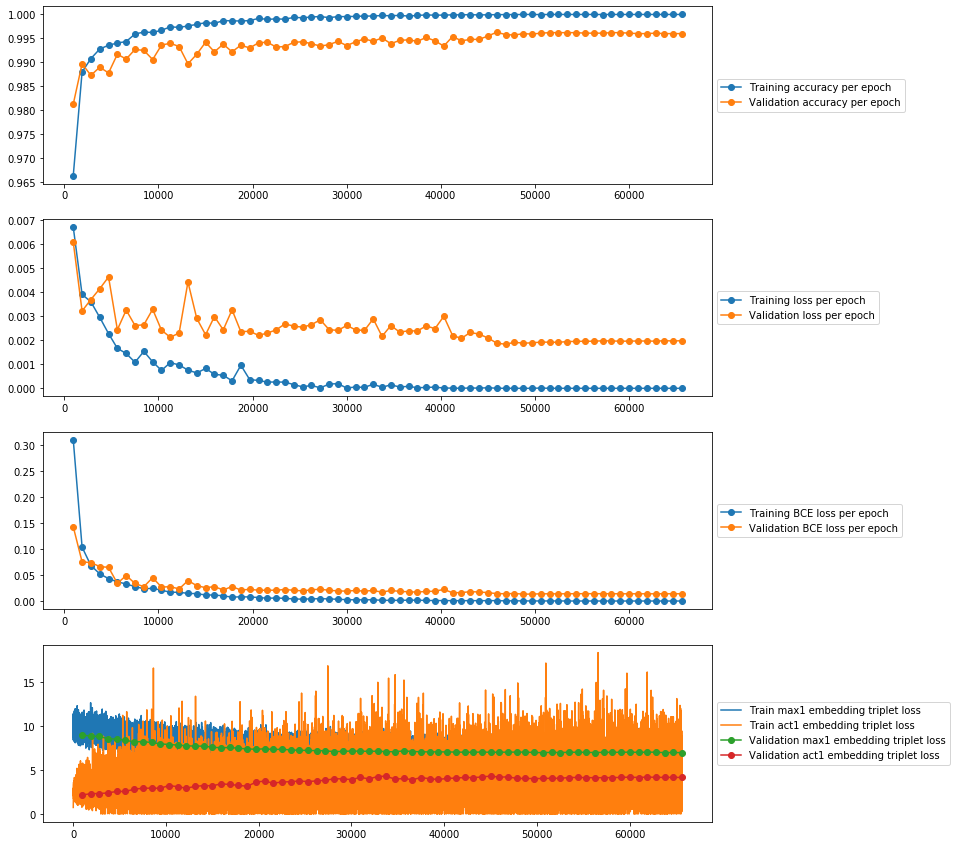

In [8]:
validator.plot()

In [9]:
sess.load("./batchnorm.ckpt.tar")

In [10]:
total_valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)
total_validator = EmbeddingSpaceValidator(total_valloader, len(select)-1, CustomOneHotAccuracy)

total_validator.run(sess)

Validating: 100%|██████████| 157/157 [00:05<00:00, 29.56it/s]


In [11]:
np.max(total_validator.val_accuracies), "Best accuracy without reg"

(0.996, 'Best accuracy without reg')

In [12]:
visualization_set = torch.utils.data.dataset.Subset(valset, np.arange(500))
dataloader = torch.utils.data.DataLoader(visualization_set, batch_size=64, shuffle=False)

tensorboard_embeddings(model, ['max1'], 
                       dataloader, 
                       valset.targets[:500], 
                       1.0 - valset.data[:500].reshape(-1, 1, 28, 28) / 255.0, 
                       './mnist_batchnorm')

tensorboard_embeddings(model, ['max2'], 
                       dataloader, 
                       valset.targets[:500], 
                       1.0 - valset.data[:500].reshape(-1, 1, 28, 28) / 255.0, 
                       './mnist_batchnorm')

tensorboard_embeddings(model, ['max3'], 
                       dataloader, 
                       valset.targets[:500], 
                       1.0 - valset.data[:500].reshape(-1, 1, 28, 28) / 255.0, 
                       './mnist_batchnorm')

tensorboard_embeddings(model, ['act1'], 
                       dataloader, 
                       valset.targets[:500], 
                       1.0 - valset.data[:500].reshape(-1, 1, 28, 28) / 255.0, 
                       './mnist_batchnorm')

tensorboard_embeddings(model, ['act2'], 
                       dataloader, 
                       valset.targets[:500], 
                       1.0 - valset.data[:500].reshape(-1, 1, 28, 28) / 255.0, 
                       './mnist_batchnorm')

tensorboard_embeddings(model, ['out'], 
                       dataloader, 
                       valset.targets[:500], 
                       1.0 - valset.data[:500].reshape(-1, 1, 28, 28) / 255.0, 
                       './mnist_batchnorm')